# Assignment 5

Name 1: Rricha Jalota <br/>
Id 2: 7010592 <br/>
Email id 1: rrja00001 <br/>
<br/>
Name 2: Pavle Markovic<br/>
Id 2: 7007913<br/>
Email id 2: pama00002<br/>

**Instructions:** Read each question carefully. <br/>
Make sure you appropriately comment your code wherever required. Your final submission should contain the completed Notebook and the respective Python files for exercises 1 and 2. There is no need to submit the data files. <br/>
Upload the zipped folder in Teams. Make sure to click on "Turn-in" after your upload your submission, otherwise the assignment will not be considered as submitted. Only one from the group should make the submisssion.

---


## Exercise 1: Out Of Vocabulary Words (3.5 points)

As you saw in the lecture, the higher the number of unseen tokens in your language corpus, the higher the OOV rate. In this exercise, you will calculate the OOV rate for different languages for different vocabulary sizes. For each corpus, preprocess the data by lowercasing the text and applying tokenisation. Since there isn't any standard tokeniser that will work on all the languages, we recommend that you write your own function called `preprocess` in `exercise_1.py`.

### 1.1 Preprocess data (0.5 points)

Preprocess the data and partition it in a 70-30% train-test split. For this, write your own function `train_test_split_data` in `exercise_1.py`. You may modify the function signature and the code in the cell below appropriately.

In [1]:
from importlib import reload
import os
import exercise_1
exercise_1 = reload(exercise_1)

# Walk through the data directory and read all the corpora
# For each corpus, read the text, preprocess it and create the train test split for each language

corpora = {} # To save the respective corpora

for file in os.listdir("data"):
    with open("data/"+file) as f:
        text = f.read()
    lang = file[file.find(".")+1:]
    pp = exercise_1.preprocess(text, lang=lang) #TODO: preprocess text
    train, test = exercise_1.train_test_split_data(pp, test_size=0.3) #TODO: split data
    #print(test)
 
    corpora[lang] = [train, test]
    

### 1.2 Calculate OOV rates (1.5 points)
For every language, construct a vocabulary by taking the 15000 most frequent tokens in the training set. Compute the OOV rate for vocabulary sizes 1k, 2k, ..., 15k. Implement this in the function `get_oov_rates` in `exercise_1.py`. 

In [2]:
oov_rates = {}
for lang, (train, test) in corpora.items():
    oov_rates[lang] = exercise_1.get_oov_rates(train, test)

### 1.3 Plotting OOV rates (1 point) 
* Using the loglog scale, plot the OOV rate against the vocabulary size for all the languages in a single plot. Make sure your legend identifies the languages appropriately and you label the axes.

* Describe your observations in 3-4 sentences.

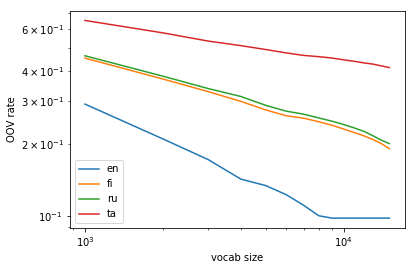

In [3]:
exercise_1.plot_oov_rates(oov_rates)

As the vocab size increases, the OOV rate for all languages decreases, except for English, wherein after a certain vocabulary size, the OOV rate stagnates and does not decrease anymore with increasing vocab size. Across all the languages, Tamil shows the highest OOV rate, which does not show much decrease (as compared to other languages) even at the largest vocabulary size. The plot can also be seen in terms of morphological richness of languages. Since English is the least morphologically-rich, with increasing vocab size, new unique words are learned and hence, OOV-rate decreases so rapidly. However, for morphologically richer languages like Tamil and Russian, even after increasing the vocab size, morphological information isn't captured and hence, the OOV-rate still remains high.   

### 1.4 Handling OOV words (0.5 points)
* Before applying smoothing and backing-off models, we need to take care of the OOV words. Suggest 2 techniques to handle Out-Of-Vocabulary words your corpus.
* What are the advantages and disadvantages of each?

* OOV words can be handles using 1) character-level encoding: since a character is the smallest unit in written language, this technique can take care of all the possible words. Disadvantage: longer-words suffer from long-range dependencies. These models require longer training time as the sequence length increases with character-level models; so, the model is more prone to gradient vanishing/exploding
2) Data-driven units (subword-embeddings) eg. byte-pair encoding: It captures commonly occuring patters in text (morphologies, stem words), while keeping the vocabulary size low. It gives the benefit of both char-level and word-level language models and works well even when the word boundaries are not clear. Disadvantage: special decoding techniques are required after model training to get the output sequence in tangible format. 

## Exercise 2: Smoothing (4 points)
 
### 2.1 Additive smoothing (1 point)

In the last assignments we largely ignored the issue of unseen words, i. s. words that are not in the train set/observed data but part of the test set. A very simple method to account for unseen words is [additive smoothing](https://en.wikipedia.org/wiki/Additive_smoothing). It assigns a small 'pseudo-count' to all unseen words AND to the words already in the language model, and then uses the updated counts to estimate the n-gram probabilities. The formula for unigram probabilities is:
\begin{equation}
p(w_i) = \frac{C(w_i) + \alpha}{N + \alpha |V|}
\end{equation}

Where
* $C(w_i)$ is the empirical count of the unigram $w_i$
* $N$ is the number of unigrams in the train set
* $|V|$ is the size of the vocabulary after smoothing
* $\alpha$ is the additive count.

If $\alpha = 1$ this is known as *Laplace* smoothing, if $0 < \alpha < 1$ *Lidstone* smoothing.

1. How would you estimate the bigram probability $p(w_i|w_{i-1})$ and the general case $p(w_i|w_{i-1}, ..., w_{n-i+1})$? Explain each part of the formula. (0.5 points)
2. Is it a good idea to set $\alpha$ to 1? What could be a more reasonable value, and why? (0.5 points)

### 2.2 Language model class (3 points)

Until now, you have implemented language models as a series of Python functions. We have provided to you a class skeleton in `lm.py` that should do all the tricks you need to estimate a language model. You will use the same corpora and train/test split as in Exercise 1.

1. Complete the implementation of the `LanguageModel` class. You may estimate the parameters of the language model as you like, but the method `perplexity` should perform the perplexity calculation (as in the below code block), and the method `lidstone_smoothing` should smooth the data. You may define new methods or change the signatures of existing ones, as long as you comment on your changes. Make sure that the relative frequencies and the conditional probabilities for each history sum up to 1. (1.5 points)

2. Choose $\alpha = 1$. Then, estimate $N = 1,2,3$ language models for the corpora from Exercise 1, and plot perplexity vs. $n$ for each of them. Do so by implementing the function `plot_pp` in `exercise_2.py` Do you observe any differences between the languages? Explain what you see in 3-4 sentences. (1 point)


##### 2.1 
1. For bigram probability, the formula would be:
    $$
    p(w_i|w_{i-1}) = \frac{C(w_i, w_{i-1}) + \alpha}{C(w_{i-1}) + \alpha |V_{(w_{i-1}, *)}|} 
    $$
    Where

    $C(w_i, w_{i-1})$ is the empirical count of the bigram $(w_i, w_{i-1})$ in the train set.
    $C(w_{i-1})$ is the count of unigram in the train set
    $|V|$ is the size of the shared (test and train) vocabulary after smoothing (each bigram that starts with $w_{i-1}$)
    $\alpha$ is the additive count.
    For general ngram probability, it would be:
    $$
    p(w_i|w_{i-1}, ..., w_{n-i+1}) = \frac{C(w_i, w_{i-1}, ..., w_{n-i+1}) + \alpha}{C(w_{i-1}, ..., w_{n-i+1}) + \alpha |V_{(w_{i-1}, ..., w_{n-i+1}, *)}|} 
    $$

    Where

    $C(w_i, w_{i-1}, ..., w_{n-i+1})$ is the empirical count of the ngram $(w_i, w_{i-1}, ..., w_{n-i+1})$ in the train set.
    $C(w_{i-1}, ..., w_{n-i+1})$ is the count of ngram - 1 in the train set
    $|V|$ is the size of the shared (test and train) vocabulary after smoothing (each ngram start with $w_{i-1}, ..., w_{n-i+1}$)
    $\alpha$ is the additive count.

2. It is generally not a good idea to set $\alpha$=1 because, assigning a constant value takes away too much probability mass from seen events and over-estimates the unseen events, by assigning them a higher probability mass. Rather a value that takes frequency-information into account, must be used for $\alpha$, like in the case of Good-Turing Smoothing. 

<Figure size 288x144 with 0 Axes>

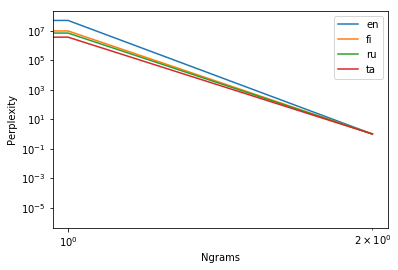

In [3]:
from importlib import reload
import lm
from collections import defaultdict
import exercise_2
lm = reload(lm)
exercise_2 = reload(exercise_2)

N = 3

PPS = defaultdict(list)

for lang, (train, test) in corpora.items():
    LM = lm.LanguageModel(train, test, N=N, alpha=1)
    for i in range(1,N+1):
        PPS[lang].append(LM.perplexity(n=i))

exercise_2.plot_pp(PPS)

Due to smoothing, the perplexity of morphologically richer languages like Tamil, Russian and Finnish decreases more rapidly than that of English language. The plot highlights the benefit of applying smoothing, as this plot shows a complete opposite trend than the previous OOV-rate-vs-vocab_size plot. 

3. Now, find a good value for $\alpha$ for the *English* corpus. Do so by estimating $K=100$ trigram language models with $\alpha = 0.0, 0.01,...,0.99,1.0$, and plot trigram perplexity vs. increasing $\alpha$. You can write the code for the loop in the code cell below, the plotting code should be in `plot_pp_vs_alpha` in `exercise_2.py`. Does the $\alpha$ coincide with your estimate in 2.1.2? (0.5 points)

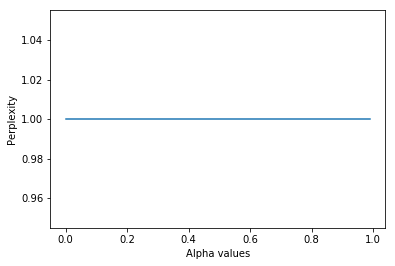

In [4]:
# only for 1 langauge?
import numpy as np
lang = "en"

N = 3
K = 100
step = 0.01
PPs = []
train, test = corpora[lang]

alphas = np.arange(0.0,1.0,0.01)

for i in alphas:
    LM = lm.LanguageModel(train, test, N=N, alpha=i)
    PPs.append(LM.perplexity(N))


exercise_2.plot_pp_vs_alpha(PPs, alphas)


## Exercise 3: Misc. (2.5 points)

## 3.1 Smoothed perplexity (1 point)

Assume you trained (MLE) an n-gram language model on datasets $D_\text{train}$ and $D_\text{test}$. You measure perplexities $p_{1,\text{train}}$ and $p_{1,\text{test}}$ respectively. You then smooth your n-gram language model and evaluate again on the two datasets, resulting in $p_{2,\text{train}}$ and $p_{2,\text{test}}$. Answer the following question with brief comments (e.g. _"X is always greater than Y because .."_). For a language model $p$, test perplexity can, for example, be computed as $2^{\frac{-1}{|D_\text{test}|} \sum_{w \in D_\text{test}}\log p(w|h)}$ and train perplexity as $2^{\frac{-1}{|D_\text{train}|} \sum_{w \in D_\text{train}}\log p(w|h)}$.

1. What is the relation of $p_{1,\text{train}}$ and $p_{1,\text{test}}$?
2. What is the relation of $p_{2,\text{train}}$ and $p_{2,\text{test}}$?
3. What is the relation of $p_{1,\text{train}}$ and $p_{2,\text{train}}$?
4. What is the relation of $p_{1,\text{test}}$ and $p_{2,\text{test}}$?
5. How does $n$ size affect the perplexities?

## 3.2 Infinite smoothing (0.5 points)

What distribution would you get if you applied additive or absolute discounting (choose one) smoothing infinitely? e.g. if $F_\text{smooth}$ is a function that smooths a language model (either additive or absolute discounting) and $\text{lm}^{(n+1)} = F_\text{smooth}(\text{lm}^{(n)})$. What will the language model $\lim_{n\rightarrow \infty} \text{lm}^{(n)}$ look similar to?

## 3.3 Convex combination of LM models (1 point)

Consider the following quantity based on two independent language models $p_1$ and $p_2$.

$f_3(w|h) = \beta_1\cdot p_1(w|h) + \beta_2\cdot p_2(w|h)$ where $\beta_1 + \beta_2 = 1$ and $\beta_1 \ge 0, \beta_2 \ge 0$

- Is it still a language model (probability distribution given history $h$)? Show that all properties hold or find a counterexample for each: (1) non-negativity, (2) summation to 1 and (3) $\sigma$-additivity. See [Wikipedia - Probability Axioms](https://en.wikipedia.org/wiki/Probability_axioms). (0.5 points)
- What would be the possible gain of using the given function as a language model? (0.5 points)

#### Answer 3.1 
1. $p_{1,\text{train}}$ is less than $p_{1,\text{test}}$ because during training, the model has already seen examples from the training data and infact, learns its behavior from it. In contrast, test data might contain tokens that the model has not previously seen before, thereby resulting in a higher perplexity on the test dataset.

2. $p_{2,\text{train}}$ would be the same as $p_{1,\text{train}}$ and will be still lower than $p_{2,\text{test}}$. Smoothing helps in reducing the perplexity but since the model learns its behavior from the training set and has seen all the tokens already, the perplexity on the training set would be lower and infact, this might also depend on the hyperparameter values set. ($\alpha$) 

3. $p_{1,\text{train}}$ would be the same as $p_{2,\text{train}}$ because the effect of smoothing is seen only when unseen examples from test set are encountered. 

4. $p_{1,\text{test}}$ will be greater than $p_{2,\text{test}}$ because after smoothing, some probability mass from the higher counts is assigned to the zero counts (i.e. the words which only occur in test set). This makes the distribution a little less discontinuous. Hence, smoothing causes improvement in perplexity and therefore becomes less than what it was before smoothing.

5. Increasing $n$, lowers perplexity. This is because, as more context is taken into account, the number of potential words that follow a set of $n-1$ words reduces (i.e. the certainity of the model increases). 

#### Answer 3.2  
The LM distribution would look similar to uniform distribution.

#### Answer 3.3 

(1) non-negativity
As $\beta_1 \ge 0, \beta_2 \ge 0$, $f_3(w|h) \ge 0$ since $p_1(w|h)$ and $p_2(w|h)$ are also a non-negative quantity. Thus, $f_3(w|h)$ as a whole would be always non-negative.

(2) summation to 1
Given two independent LMs $p_1$ and $p_2$, $$\sum_{i} p_1(w_i|h_i) = 1$$and$$\sum_{i} p_2(w_i|h_i) = 1$$. Now, $$\sum_{i} f_3(w_i|h_i) = \beta_1\cdot \sum_{i} p_1(w_i|h_i) + \beta_2\cdot \sum_{i} p_2(w_i|h_i)$$  As $\beta_1 + \beta_2 = 1$,   $$\sum_{i} f_3(w_i|h_i) = \beta_1\cdot 1 + \beta_2\cdot 1$$$$\sum_{i} f_3(w_i|h_i)) = 1$$

The convex combinations of LMs, $f_3$, would work like an ensemble model ($\beta_1$ and $\beta_2$ can be frther controlled) and hence, can benefit from the performance of at least one languge model. 




## Bonus (1 point)

Read about the following special language models techniques. The provided links shold only serve as a starting point.



#### 1. [Neural language models](https://en.wikipedia.org/wiki/Language_model#Neural_network) (0.5 points)

- Describe (~5 sentences or bullet points) the working, advantages and disadvantages of NLM.

#### 2. [Class-based language models](https://www.cs.cmu.edu/~roni/11761/PreviousYearsHandouts/classlm.pdf) (0.5 points)

- What is a class-based language model?
- What issues does it address?
- Can we utilize the output for something more than just language modelling (think about other NLP problems and classes you took)?

<!-- #### 2. [Decoding](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/) (0.5p)

- What issues does beam search in the context of text generation using language models solve? -->
 <!-- and . Be specific and practical in your answers and support your arguments with evidence.  -->